In [1]:
import sys
import time
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

#from numpy.core.umath_tests import inner1d
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score,classification_report,precision_score,recall_score
from sklearn.model_selection import train_test_split, cross_val_score,  RepeatedStratifiedKFold,RandomizedSearchCV, GridSearchCV

# modelos
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import  ExtraTreesClassifier,VotingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# data1 : without id
data = data.drop(['id'], axis=1)

In [5]:
label = [1,2,3,4,5]
data["age_mean"] = pd.cut(data["age"], 5, labels = label)
data["age_mean"].value_counts()
bmi_group = data.groupby("age_mean")["bmi"].mean() 
bmi_group

age_mean
1    20.787661
2    28.601332
3    31.425088
4    31.580618
5    29.415118
Name: bmi, dtype: float64

In [6]:
def bmi_val(cols): 
    bmi = cols[0]
    age_mean = cols[1]
    
    if pd.isnull(bmi):
        if age_mean == 1:
            return 20.7
        elif age_mean == 2:
            return 28.6
        elif age_mean == 3:
            return 31.4
        elif age_mean == 4:
            return 31.6
        elif age_mean == 5:
            return 29.4
    else:
        return bmi

In [7]:
data["bmi"] = data[["bmi","age_mean"]].apply(bmi_val, axis=1)
data.isnull().sum() 

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
age_mean             0
dtype: int64

In [8]:
data.gender = data.gender.apply(
                                lambda x: 0 
                                if ((x == 'Female') or (x == 'Other')) 
                                else 1)

In [9]:
print(data.gender.value_counts())

0    2995
1    2115
Name: gender, dtype: int64


In [10]:
data['age'] = data['age'].apply(lambda x: round(x))
data['age']

0       67
1       61
2       80
3       49
4       79
        ..
5105    80
5106    81
5107    35
5108    51
5109    44
Name: age, Length: 5110, dtype: int64

In [11]:
# Encode the target tag with values between 0 and n_classes-1 / encode the classification characteristics as a one-key numeric array
one_hot = OneHotEncoder()

data['gender'] = pd.Categorical(data['gender'])
d_gender = pd.get_dummies(data['gender'],prefix='gender_encoded')

data['smoking_status']=pd.Categorical(data['smoking_status'])
d_smoking_status=pd.get_dummies(data['smoking_status'],prefix='smoking_status_encode')

data['work_type'] = pd.Categorical(data['work_type'])
d_work_type = pd.get_dummies(data['work_type'], prefix = 'work_type_encoded')

data['Residence_type'] = pd.Categorical(data['Residence_type'])
d_Residence_type = pd.get_dummies(data['Residence_type'], prefix = 'Residence_type_encoded')

data['ever_married'] = pd.Categorical(data['ever_married'])
d_ever_married = pd.get_dummies(data['ever_married'], prefix = 'ever_married_encoded')

data.drop(['gender'], axis=1, inplace=True)
data.drop(["work_type"], axis=1, inplace=True)
data.drop(["smoking_status"], axis=1, inplace=True)
data.drop(["Residence_type"], axis=1, inplace=True)
data.drop(["ever_married"], axis=1, inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                5110 non-null   int64   
 1   hypertension       5110 non-null   int64   
 2   heart_disease      5110 non-null   int64   
 3   avg_glucose_level  5110 non-null   float64 
 4   bmi                5110 non-null   float64 
 5   stroke             5110 non-null   int64   
 6   age_mean           5110 non-null   category
dtypes: category(1), float64(2), int64(4)
memory usage: 244.9 KB


In [12]:
data=pd.concat([data,d_gender],axis=1)
data=pd.concat([data,d_work_type],axis=1)
data=pd.concat([data,d_smoking_status],axis=1)
data=pd.concat([data,d_Residence_type],axis=1)
data=pd.concat([data,d_ever_married],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   age                                    5110 non-null   int64   
 1   hypertension                           5110 non-null   int64   
 2   heart_disease                          5110 non-null   int64   
 3   avg_glucose_level                      5110 non-null   float64 
 4   bmi                                    5110 non-null   float64 
 5   stroke                                 5110 non-null   int64   
 6   age_mean                               5110 non-null   category
 7   gender_encoded_0                       5110 non-null   uint8   
 8   gender_encoded_1                       5110 non-null   uint8   
 9   work_type_encoded_Govt_job             5110 non-null   uint8   
 10  work_type_encoded_Never_worked         5110 non-null   uint8

Using SMOTE 

In [13]:
k_values = [1, 2, 3, 4, 5, 6, 7]
X = data.drop(['stroke'], axis=1)
y = data.stroke

In [14]:
k_values = [1, 2, 3, 4, 5, 6, 7]
X = data.drop(['stroke'], axis=1)
y = data.stroke

k_scores = []
for k in k_values:
    # define pipeline
    rf = RandomForestClassifier()
    over  = SMOTE(sampling_strategy = 0.1, k_neighbors = k)
    steps = [('over', over), ('model', rf)]
    
    pipeline = Pipeline(steps=steps)
    
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    scores = cross_val_score(rf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    k_scores.append((k, score))
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.798
> k=2, Mean ROC AUC: 0.795
> k=3, Mean ROC AUC: 0.797
> k=4, Mean ROC AUC: 0.799
> k=5, Mean ROC AUC: 0.797
> k=6, Mean ROC AUC: 0.802
> k=7, Mean ROC AUC: 0.793


Find the best k value of SMOTE 

In [15]:
sorted(k_scores, key=lambda tup: tup[1])

[(7, 0.793317570270095),
 (2, 0.7947548722195464),
 (3, 0.7972083970615987),
 (5, 0.7974112782833787),
 (1, 0.7981923896479947),
 (4, 0.7991971435653463),
 (6, 0.8018924886556644)]

In [16]:
best_k = sorted(k_scores, key=lambda tup: tup[1])[-1][0]
best_k

6

In [17]:
over  = SMOTE(k_neighbors=best_k)
steps = [('over', over)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)
counter = Counter(y)
print('Number of stork(1) and non-stroke(0) data:', counter)

Number of stork(1) and non-stroke(0) data: Counter({1: 4861, 0: 4861})


delete the null value

In [18]:
 X.isnull().sum()

age                                        0
hypertension                               0
heart_disease                              0
avg_glucose_level                          0
bmi                                        0
age_mean                                 598
gender_encoded_0                           0
gender_encoded_1                           0
work_type_encoded_Govt_job                 0
work_type_encoded_Never_worked             0
work_type_encoded_Private                  0
work_type_encoded_Self-employed            0
work_type_encoded_children                 0
smoking_status_encode_Unknown              0
smoking_status_encode_formerly smoked      0
smoking_status_encode_never smoked         0
smoking_status_encode_smokes               0
Residence_type_encoded_Rural               0
Residence_type_encoded_Urban               0
ever_married_encoded_No                    0
ever_married_encoded_Yes                   0
dtype: int64

In [19]:
X = X.drop(['age_mean'], axis=1)  

In [20]:
X.isnull().sum()

age                                      0
hypertension                             0
heart_disease                            0
avg_glucose_level                        0
bmi                                      0
gender_encoded_0                         0
gender_encoded_1                         0
work_type_encoded_Govt_job               0
work_type_encoded_Never_worked           0
work_type_encoded_Private                0
work_type_encoded_Self-employed          0
work_type_encoded_children               0
smoking_status_encode_Unknown            0
smoking_status_encode_formerly smoked    0
smoking_status_encode_never smoked       0
smoking_status_encode_smokes             0
Residence_type_encoded_Rural             0
Residence_type_encoded_Urban             0
ever_married_encoded_No                  0
ever_married_encoded_Yes                 0
dtype: int64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=42)

In [22]:
k_val = []
score = []
for i in range(3, 10):
    model = KNeighborsClassifier(n_neighbors=i, algorithm='auto', n_jobs=6)
    k_val.append(i)
    model.fit(X_train, y_train)
    preds_KNN = model.predict(X_test)
    score_KNN = accuracy_score(y_test, preds_KNN)
    score.append(score_KNN)
    print('k = {}, Accuracy = {} ' .format (i, np.mean(y_test == preds_KNN)))

k = 3, Accuracy = 0.9105398457583548 
k = 4, Accuracy = 0.9167095115681234 
k = 5, Accuracy = 0.9053984575835475 
k = 6, Accuracy = 0.9110539845758355 
k = 7, Accuracy = 0.8966580976863753 
k = 8, Accuracy = 0.9053984575835475 
k = 9, Accuracy = 0.8940874035989718 


k = 3, Accuracy = 0.9105398457583548
k = 4, Accuracy = 0.9167095115681234
k = 5, Accuracy = 0.9053984575835475
k = 6, Accuracy = 0.9110539845758355
k = 7, Accuracy = 0.8966580976863753
k = 8, Accuracy = 0.9053984575835475
k = 9, Accuracy = 0.8940874035989718


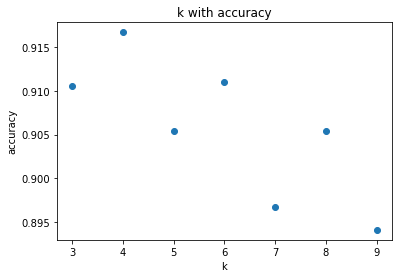

In [23]:
#show the accuracy of different k
for i in range(0,7): 
    print('k = {}, Accuracy = {}'.format(k_val[i],score[i]))

plt.scatter(k_val,score)
plt.title("k with accuracy")
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

In [24]:
KNN = KNeighborsClassifier(n_neighbors = 4, algorithm='auto', n_jobs=6)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=6, n_neighbors=4)

In [25]:
preds_knn = KNN.predict(X_test)
print(classification_report(y_test, preds_knn))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       973
           1       0.88      0.97      0.92       972

    accuracy                           0.92      1945
   macro avg       0.92      0.92      0.92      1945
weighted avg       0.92      0.92      0.92      1945

